In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import requests
import json
from datetime import date, timedelta
from numpy import array
import pandas as pd
import nltk
from nltk.probability import FreqDist
from datetime import date, timedelta, datetime

import re, string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) 

stop_add=['con','com','media','excelsior','amp','ref','mx','5etfw','data','img']

for i in range(0,len(stop_add)):
    stop_words.add(stop_add[i])


#dfnotas = pd.read_csv('EXCELSIOR_ENERO_SEPTIEMBRE.csv')
#dfnotas = pd.read_csv('Salud180.csv')
dfnotas = pd.read_csv('SALUD2020.csv')
#dfnotas = pd.read_csv('NOTAS_EXCELSIOR_ENERO.csv')

#dfnotas = dfnotas.fillna(0)

[nltk_data] Downloading package stopwords to C:\Users\Diego
[nltk_data]     Esteva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#ELIMINA NOTAS SIN PVS
nulos=[]

#dfnotas['Número de vistas de página']=dfnotas['Número de vistas de página'].astype(int)
dfnotas = dfnotas.fillna(0)

for i in range(0,len(dfnotas.index)):
    if dfnotas.iloc[i]['Número de vistas de página'] == 0:
        nulos.append(i)

for i in range(0,len(nulos)):        
    dfnotas=dfnotas.drop(nulos[i])

dfnotas.head(5)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página
0,salud180,"28 ene 2021, 19:58:35",Descubre qué tipo de glúteos tienes y qué ejer...,2021-01-28,14:58:35,https://www.salud180.com/nutricion-y-ejercicio...,0.0,_ejercicio_ejercicios glúteos_tipos de glúteos...,<p>Una vez escuche: “los hombres creen que una...,1802730.0
1,salud180,"5 ago 2020, 17:19:40",Trucos para limpiar el baño rápido y dejarlo “...,2020-08-05,12:19:40,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Cómo limpiar rápido el baño_Trucos para limpi...,"<p dir=""ltr""><span id=""docs-internal-guid-ad0d...",1607281.0
2,salud180,"27 ene 2021, 15:06:08",7 abdominales de pie para aplanar el abdomen b...,2021-01-27,10:06:08,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_abdomen_ejercicios abdomen_abdominales pie_ab...,<p><strong>¡Estoy harta de la “panza”! Llevo s...,1555385.0
3,salud180,"11 may 2020, 18:17:27","Plantas que alejan a las arañas, hormigas, mos...",2020-05-11,13:17:27,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_plantas que alejan arañas_plantas que alejan ...,"<p>No hay peor <strong>pesadilla que ""sudar la...",1448039.0
4,salud180,"4 may 2020, 15:35:55",Plantas que alejan a las cucarachas y moscas d...,2020-05-04,10:35:55,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_plantas que alejan cucarachas_plantas que ale...,<p>No importa si tu<strong> casa está relucien...,1126486.0


In [4]:
def limpiar_texto(texto):

    link_eliminar=[]
    link_ubi=[]
    acum=[]
    
    for i in range (0,len(texto)):  #Busca la posicion en el texto de los "<" y ">" 
        if '<' == texto[i]:
            link_ubi.append(i)
            
        elif  '>' == texto[i]:
            link_ubi.append(i)
            
            link_eliminar.append(link_ubi)
            link_ubi=[]
              
  #  print(link_eliminar)
    for i in range (0,len(link_eliminar)):  #recuperar lo que esta dentro de "<" y ">"(indexaciones,links,codigos,etc) y mete ese texto en una lista
        textoaux=texto[(link_eliminar[i])[0]:(link_eliminar[i])[1]+1]
        acum.append(textoaux)
    
    for i in range(0,len(acum)): #elimina todas las coincidencias de la lista que creamos en el ciclo anterior
        texto=texto.replace(acum[i],"")  
    
    return texto

In [5]:
def eliminar_caracteresesp(texto):

#    link_eliminar=[]
#    link_ubi=[]
#    acum=[]
#    
#    for i in range (0,len(texto)):  #Busca la posicion en el texto de los "<" y ">" 
#        if '<' == texto[i]:
#            link_ubi.append(i)
#            
#        elif  '>' == texto[i]:
#            link_ubi.append(i)
#            
#            link_eliminar.append(link_ubi)
#            link_ubi=[]
#              
#  #  print(link_eliminar)
#    for i in range (0,len(link_eliminar)):  #recuperar lo que esta dentro de "<" y ">"(indexaciones,links,codigos,etc) y mete ese texto en una lista
#        textoaux=texto[(link_eliminar[i])[0]:(link_eliminar[i])[1]+1]
#        acum.append(textoaux)
#    
#    for i in range(0,len(acum)): #elimina todas las coincidencias de la lista que creamos en el ciclo anterior
#        texto=texto.replace(acum[i],"")  
    
    
    texto=texto.lower()    #Hace minusculas todas las letras del cuerpo

    texto=re.sub('[%s]' % re.escape(string.punctuation), ' ', texto) #Elimina puntuacion

    auxtexto=nltk.word_tokenize(texto)
    auxtexto2=[]  

    for w in auxtexto:  #Elimina articulos gramaticales
        if w not in stop_words: 
            auxtexto2.append(w)
    return auxtexto2



In [31]:
#dfnotas.iloc[2]['cuerpo']

In [6]:
no_palabras_titulo=[]
repetidas=[]
no_palabras_cuerpo=[]
no_letras_url=[]
diccionario_frecuencias = {}
mas_repetidasaux=''
mas_repetidas=[]
vocabulario_cuerpo =[]
frecuentes_cuerpo=[]
nuevo_cuerpo=[]
TieneKeyValue=[]
CountTags=[]
CountParrafos=[]
CountLinks=[]
CountImagenes=[]


#Convierte los datos en tipo necesario
dfnotas['title']=dfnotas['title'].astype(str) 
dfnotas['cuerpo']=dfnotas['cuerpo'].astype(str)
dfnotas['tags']=dfnotas['tags'].astype(str)
#dfnotas['Fecha'] = pd.to_datetime(dfnotas['Fecha'], format="%d/%m/%Y")

for i in range(0,len(dfnotas.index)):

    titulo=dfnotas.iloc[i]['title'] #recorre los titulos del dt por fila
    cuerpo=dfnotas.iloc[i]['cuerpo']

    tokens_titulo = nltk.word_tokenize(titulo) #separa el titulo por palabras
    
    no_letras_url.append(len(dfnotas.iloc[i]['url']))
    no_palabras_titulo.append(len(tokens_titulo))  #agrega a la lista la cantidad de palabras de cada titulo
    

    
    CountParrafos.append(dfnotas.iloc[i]['cuerpo'].count("<p>")-4)
    CountImagenes.append(dfnotas.iloc[i]['cuerpo'].replace('Images','').count("Image"))#Cuenta la cantidad de parrafos (-4 es por los parrafos que siempre estan implicitos en las notas)
    CountLinks.append(dfnotas.iloc[i]['cuerpo'].count("<a")) #Cuenta cantidad de links
    
    for palabra in tokens_titulo:                   #Agrega todas las palabras que se repitan mas de dos veces en el titulo
        if palabra in diccionario_frecuencias:
            diccionario_frecuencias[palabra] += 1
        else:
            diccionario_frecuencias[palabra] = 1

    for palabra in diccionario_frecuencias:
        frecuencia = diccionario_frecuencias[palabra]
    
        if frecuencia >= 2 : 
            mas_repetidas.append(palabra)
            mas_repetidasaux=mas_repetidasaux+palabra+","
    
    repetidas.append(mas_repetidas)
    mas_repetidas=[]
    diccionario_frecuencias = {}
    
    
    
######################################################################
#CONTEO DE TAGS
    
    if (dfnotas.iloc[i]['tags']) != 0 :
        TieneKeyValue.append('Si')
        CountTags.append(dfnotas.iloc[i]['tags'].count("_")+1) #cuantos Tags hay en la notas
        
    else:
        #TagsEsp.append("Null")
        CountTags.append(0)
        TieneKeyValue.append('No')
    
#####################################
#CONTEO DE PALABRAS FRECUENTES    

    cuerpo=limpiar_texto(cuerpo)
    cuerpo=cuerpo.replace('\n','')
 #   cuerpo=cuerpo.replace('\xa','')
    nuevo_cuerpo.append(cuerpo)
    
    tokens_cuerpo = nltk.word_tokenize(cuerpo) #separa el cuerpo por palabras
    
    no_palabras_cuerpo.append(len(tokens_cuerpo))
    vocabulario_cuerpo.append(set(tokens_cuerpo))

    auxcuerpo2=eliminar_caracteresesp(cuerpo)

        
    frecuentes_cuerpo.append(FreqDist(auxcuerpo2).most_common(10)) #crea una lista con las 10 palabras mas frecuente del cuerpo y su no. de repeticiones

#Se añaden columnas con las nuevas metricas

dfnotas['cuerpo']=nuevo_cuerpo
dfnotas['No.Letras_Url']=no_letras_url                  #cantidad de letras en url
dfnotas['No.Palabras_Titulo']=no_palabras_titulo        #Cantidad de palabras en el titulo
dfnotas['Mas_Frecuentes_Titulo']=repetidas              #Palabras mas frecuentes en el titulo
dfnotas['No.Palabras_Cuerpo']=no_palabras_cuerpo        #Cantidad de palabras en el cuerpo de la nota
dfnotas['No.Parrafos']=CountParrafos                    #Cantidad de parrafos en el cuerpo
dfnotas['No.Links']=CountLinks                          #Cantidad de de links en la nota
dfnotas['No.Imagenes']=CountImagenes
dfnotas['Vocabulario_Cuerpo']=vocabulario_cuerpo        #Vocabulario usado en el cuerpo
#dfnotas['Mas_Frecuentes_Cuerpo ']=frecuentes_cuerpo     #Palabras mas frecuente en el cuerpo
dfnotas['Tiene_Tags']=TieneKeyValue                     #Dice se pusieron tags o no en la nota
dfnotas['No.Tags']=CountTags                            #Cantidad de tags en la nota

dfnotas.head(5)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,No.Letras_Url,No.Palabras_Titulo,Mas_Frecuentes_Titulo,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags
0,salud180,"28 ene 2021, 19:58:35",Descubre qué tipo de glúteos tienes y qué ejer...,2021-01-28,14:58:35,https://www.salud180.com/nutricion-y-ejercicio...,0.0,_ejercicio_ejercicios glúteos_tipos de glúteos...,Una vez escuche: “los hombres creen que una mu...,1802730.0,123,16,"[qué, y]",247,3,3,1,"{publicado, a, ejercitarte, nutrientes, ¡DESLI...",Si,7
1,salud180,"5 ago 2020, 17:19:40",Trucos para limpiar el baño rápido y dejarlo “...,2020-08-05,12:19:40,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Cómo limpiar rápido el baño_Trucos para limpi...,¿A quién no le gustaría tener el baño de la ca...,1607281.0,114,13,[],418,4,7,2,"{toda, impecable.No, les, acuerdo, publicado, ...",Si,13
2,salud180,"27 ene 2021, 15:06:08",7 abdominales de pie para aplanar el abdomen b...,2021-01-27,10:06:08,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_abdomen_ejercicios abdomen_abdominales pie_ab...,¡Estoy harta de la “panza”! Llevo semanas a di...,1555385.0,85,16,[de],270,9,5,2,"{horrible, mejor, yo, tienen, marcar, única, A...",Si,8
3,salud180,"11 may 2020, 18:17:27","Plantas que alejan a las arañas, hormigas, mos...",2020-05-11,13:17:27,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_plantas que alejan arañas_plantas que alejan ...,"No hay peor pesadilla que ""sudar la gota gorda...",1448039.0,117,19,"[,]",442,16,11,1,"{toda, alacranes, acuerdo, moscos, a, tener, i...",Si,14
4,salud180,"4 may 2020, 15:35:55",Plantas que alejan a las cucarachas y moscas d...,2020-05-04,10:35:55,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_plantas que alejan cucarachas_plantas que ale...,No importa si tu casa está reluciente de lo li...,1126486.0,104,11,[],334,13,13,1,"{servido, toda, a, indeseados, tener, insectic...",Si,10


In [7]:
topic=[]

for i in range(0,len(dfnotas.index)):
    
    link=dfnotas.iloc[i]['url']
    topicaux=''
    diagonal=0
    for letra in link :
        if letra == '/' :
            diagonal=diagonal+1
            continue
        if diagonal == 3 :
            topicaux=topicaux+letra
            continue
        if diagonal ==4:
            break
    if len(topicaux) < 20:
        topic.append(topicaux)
    else:
        topic.append('null')


#for i in range(0,len(topic)):
#    
#    if 'adrenalina' in topic[i] :
#        topic[i]=1
#    elif 'comunidad' in topic[i]:
#        topic[i]=2
#    elif 'funcion' in topic[i]:
#        topic[i]=5
#    elif 'nacional' in topic[i]:
#        topic[i]=3
#    elif 'global' in topic[i]:
#        topic[i]=4
#    elif 'trending' in topic[i]:
#        topic[i]=6
#    else:
#        topic[i]=0
        
dfnotas['Topic']=topic
dfnotas.head(3)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras_Titulo,Mas_Frecuentes_Titulo,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags,Topic
0,salud180,"28 ene 2021, 19:58:35",Descubre qué tipo de glúteos tienes y qué ejer...,2021-01-28,14:58:35,https://www.salud180.com/nutricion-y-ejercicio...,0.0,_ejercicio_ejercicios glúteos_tipos de glúteos...,Una vez escuche: “los hombres creen que una mu...,1802730.0,...,16,"[qué, y]",247,3,3,1,"{publicado, a, ejercitarte, nutrientes, ¡DESLI...",Si,7,null
1,salud180,"5 ago 2020, 17:19:40",Trucos para limpiar el baño rápido y dejarlo “...,2020-08-05,12:19:40,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Cómo limpiar rápido el baño_Trucos para limpi...,¿A quién no le gustaría tener el baño de la ca...,1607281.0,...,13,[],418,4,7,2,"{toda, impecable.No, les, acuerdo, publicado, ...",Si,13,salud-dia-a-dia
2,salud180,"27 ene 2021, 15:06:08",7 abdominales de pie para aplanar el abdomen b...,2021-01-27,10:06:08,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_abdomen_ejercicios abdomen_abdominales pie_ab...,¡Estoy harta de la “panza”! Llevo semanas a di...,1555385.0,...,16,[de],270,9,5,2,"{horrible, mejor, yo, tienen, marcar, única, A...",Si,8,salud-dia-a-dia


In [8]:
#CLASIFICACION DE HORARIO DE PUBLICACION
horario_publicacion=[]
solo_hora=[]

madrugada=datetime.strptime('00:00:00', '%H:%M:%S') #Convertimos strings a formato fecha
mañana=datetime.strptime('05:00:00', '%H:%M:%S')
tarde=datetime.strptime('12:00:00', '%H:%M:%S')
noche=datetime.strptime('19:00:00', '%H:%M:%S')

for i in range(0,len(dfnotas.index)):
    
    horarioaux=dfnotas.iloc[i]['Hora'] 
    horarioaux=datetime.strptime(horarioaux, '%H:%M:%S')
    solo_hora.append(horarioaux.hour) #Hace una lista con solo la hora de publiacion de las notas

    if horarioaux >= madrugada and horarioaux < mañana : #Se clasifican las notas segundo su hora de publicacion en, madrugada, mañana, tarde y noche
        horario_publicacion.append('Madrugada')
    elif horarioaux >= mañana and horarioaux < tarde :
        horario_publicacion.append('Mañana')
    elif horarioaux >= tarde and horarioaux < noche  :
        horario_publicacion.append('Tarde')
    elif horarioaux >= noche :
        horario_publicacion.append('Noche')
    else:
        horario_publicacion.append('0')
            
    
#   if horarioaux >= madrugada and horarioaux < mañana :
#       horario_publicacion.append(1)
#   elif horarioaux >= mañana and horarioaux < tarde :
#       horario_publicacion.append(2)
#   elif horarioaux >= tarde and horarioaux < noche  :
#       horario_publicacion.append(3)
#   elif horarioaux >= noche :
#       horario_publicacion.append(4)
#   else:
#       horario_publicacion.append(0)

dfnotas['Horario_de_Publicacion']=horario_publicacion #Clasificacion en madrugada, mañana....
dfnotas['Solo_Hora']=solo_hora #Solo la hora, no cuenta minutos y segundos
dfnotas.head(3)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora
0,salud180,"28 ene 2021, 19:58:35",Descubre qué tipo de glúteos tienes y qué ejer...,2021-01-28,14:58:35,https://www.salud180.com/nutricion-y-ejercicio...,0.0,_ejercicio_ejercicios glúteos_tipos de glúteos...,Una vez escuche: “los hombres creen que una mu...,1802730.0,...,247,3,3,1,"{publicado, a, ejercitarte, nutrientes, ¡DESLI...",Si,7,null,Tarde,14
1,salud180,"5 ago 2020, 17:19:40",Trucos para limpiar el baño rápido y dejarlo “...,2020-08-05,12:19:40,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Cómo limpiar rápido el baño_Trucos para limpi...,¿A quién no le gustaría tener el baño de la ca...,1607281.0,...,418,4,7,2,"{toda, impecable.No, les, acuerdo, publicado, ...",Si,13,salud-dia-a-dia,Tarde,12
2,salud180,"27 ene 2021, 15:06:08",7 abdominales de pie para aplanar el abdomen b...,2021-01-27,10:06:08,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_abdomen_ejercicios abdomen_abdominales pie_ab...,¡Estoy harta de la “panza”! Llevo semanas a di...,1555385.0,...,270,9,5,2,"{horrible, mejor, yo, tienen, marcar, única, A...",Si,8,salud-dia-a-dia,Mañana,10


In [9]:
dfnotas['Topic'].unique()

array(['null', 'salud-dia-a-dia', 'salud-a-z', 'bienestar180',
       'enforma180', 'sexualidad', 'sexualidad180', 'adultos-mayores',
       'coronavirus', 'salud-dia-dia', 'topico', 'galeria', 'SALUD-A-Z',
       'abdominales', 'jovenes', 'anemia', 'SALUD-DIA-DIA', 'artritis',
       'cancer-de-prostata', 'video', 'node', 'anorexia',
       'cancer-de-mama', 'bulimia', 'mananera-7-mayo', 'acupuntura'],
      dtype=object)

In [10]:
topics=dfnotas['Topic'].unique() #Hace un arreglo con los valores unicos de topic
#len(dfnotas['Topic'].unique()) #Cantidad de valores unicos
#topics

for i in range(len(topics)):

    count=dfnotas['Topic'].str.contains(topics[i]).value_counts()[True] #Cuenta la cantidad de notas que hay de cada Topic
    
    indice=dfnotas.loc[dfnotas['Topic'] == topics[i]].index #Da el indice de las notas por topics
    
    if count<=50 :
        dfnotas=dfnotas.drop(indice,axis=0)  #elimina todas las notas del topic que no supere las 50 notas


dfnotas['Topic'].unique()


array(['null', 'salud-dia-a-dia', 'salud-a-z', 'bienestar180',
       'enforma180', 'salud-dia-dia'], dtype=object)

In [12]:
indice=dfnotas.loc[dfnotas['Número de vistas de página']> 500000].index

dfnotas=dfnotas.drop(indice,axis=0)


In [13]:
dfnotas=dfnotas.reset_index(drop=True)


In [14]:
dfnotas

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora
0,salud180,"7 abr 2020, 19:04:19",Aprende a cultivar ajo en una maceta y ahorra ...,2020-04-07,14:04:19,https://www.salud180.com/salud-dia-a-dia/como-...,0.0,_qué cultivar casa_qué cultivar departamento_c...,El ajo es un ingrediente central en nuestra ga...,497286.0,...,372,9,8,2,"{amantes, acuerdo, necesitas, selenio, YAApren...",Si,24,salud-dia-a-dia,Tarde,14
1,salud180,"26 may 2022, 18:11:38",Cómo cuidar una cuna de Moisés para que florez...,2022-05-26,13:11:38,https://www.salud180.com/bienestar180/como-cui...,0.0,_qué cultivar casa_qué cultivar departamento_c...,La cuna de moisés es una de las plantas prefe...,487104.0,...,987,36,7,0,"{abundante, aprovechar, mejor, espatifilo, man...",Si,15,bienestar180,Tarde,13
2,salud180,"21 abr 2021, 19:51:12",7 ejercicios efectivos para aumentar la cadera...,2021-04-21,14:51:12,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Ejercicios Para Aumentar Cadera_como aumentar...,No todas tuvimos la suerte de nacer con la bue...,475620.0,...,310,-4,6,0,"{mejor, aumento, publicado, quieres, of, inten...",Si,21,salud-dia-a-dia,Tarde,14
3,salud180,"12 may 2021, 21:03:49",4 aceites que fortalecen y alargan las pestaña...,2021-05-12,16:03:49,https://www.salud180.com/salud-dia-a-dia/galer...,0.0,_Aceites para las pestañas_pestañas naturales_...,Una mirada expresiva no siempre va acompañada ...,474655.0,...,344,-4,5,0,"{yo, acuerdo, publicado, extensiones, of, conj...",Si,18,salud-dia-a-dia,Tarde,16
4,salud180,"27 abr 2020, 16:17:16",Plantas que puedes tener en jarrones con agua ...,2020-04-27,11:17:16,https://www.salud180.com/bienestar180/galeria/...,0.0,_Plantas en agua_plantas en jarrones con agua_...,¿A quien no le gusta tener plantas? Pues adem...,472873.0,...,369,-2,6,0,"{cuidado, abundante, purificar, toda, pasarla,...",Si,15,bienestar180,Mañana,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,salud180,"14 jul 2022, 21:57:31",3 ejercicios para personas con hipertensión,2022-07-14,16:57:31,https://www.salud180.com/nutricion-y-ejercicio...,0.0,_baila_bicicleta_correr_ejercicio físico_hiper...,De acuerdo con la Fundación Española del Coraz...,162.0,...,384,17,34,0,"{Corazón, acuerdo, diversas, fortalece, A, día...",Si,6,null,Tarde,16
4989,salud180,"9 ene 2020, 22:01:19",¿No duermes? Esta es la relación entre el inso...,2020-01-09,17:01:19,https://www.salud180.com/salud-a-z/no-duermes-...,0.0,_daños por no dormir bien_cuáles son las conse...,¿No duermes? ¿Pasas toda la noche dando vuelta...,162.0,...,407,27,5,2,"{especialmente, toda, notas, tienen, afectan, ...",Si,13,salud-a-z,Tarde,17
4990,salud180,"6 oct 2021, 20:42:21",¿El fin de la malaria se aproxima? OMS respald...,2021-10-06,15:42:21,https://www.salud180.com/salud-dia-a-dia/el-fi...,0.0,_malaria_qué es malaria_vacuna malaria_paludis...,"Escalofríos, dolor muscular, diarrea.. la mala...",162.0,...,391,8,5,1,"{riñones, vacuna, RTS, a, uso, Complicaciones,...",Si,8,salud-dia-a-dia,Tarde,15
4991,salud180,"2 ene 2020, 19:28:33",Este chip mide el riesgo de que padezcas diabetes,2020-01-02,14:28:33,https://www.salud180.com/salud-a-z/este-chip-m...,0.0,_chip determina riesgo de diabetes_hip diabete...,¿Te imaginas que pudieras saber antes de tiemp...,162.0,...,446,32,5,0,"{trabajamos, notas, dijo, otros, siglas, recom...",Si,15,salud-a-z,Tarde,14


In [ ]:
#VOCABULARIO POR TOPICS
topic=''
vocabulario_funcion=[]
vocabulario_adrenalina=[]
vocabulario_comunidad=[]
vocabulario_nacional=[]
vocabulario_global=[]
vocabulario_trending=[]
vocabularios=[]

for i in range(0,len(dfnotas.index)):
    
    topic=dfnotas.iloc[i]['Topic']
    
    if 'adrenalina' in topic :
        vocabulario_adrenalina=vocabulario_adrenalina+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo'])))) #la funcion set devuelve un conjunto, por lo que lo transformamos a lista(list()) para poder sumarlo
    elif 'comunidad' in topic:
        vocabulario_comunidad=vocabulario_comunidad+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'funcion' in topic:
        vocabulario_funcion=vocabulario_funcion+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'nacional' in topic:
        vocabulario_nacional=vocabulario_nacional+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'global' in topic:
        vocabulario_global=vocabulario_global+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'trending' in topic:
        vocabulario_trending=vocabulario_trending+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))

topics=['adrenalidad','comunidad','funcion','nacional','global','trending']
        
vocabularios.append(FreqDist(vocabulario_adrenalina).most_common(10))
vocabularios.append(FreqDist(vocabulario_comunidad).most_common(10))
vocabularios.append(FreqDist(vocabulario_funcion).most_common(10))
vocabularios.append(FreqDist(vocabulario_nacional).most_common(10))
vocabularios.append(FreqDist(vocabulario_global).most_common(10))
vocabularios.append(FreqDist(vocabulario_trending).most_common(10))



dfvocabularios=pd.DataFrame()

dfvocabularios['Topics']=topics
dfvocabularios['Vocabulario Global']=vocabularios

dfvocabularios.head()




In [35]:
#dfadrenalina=pd.DataFrame()
#
#for i in range(0,len(dfnotas.index)):
#    if dfnotas.iloc[i]['Topic']=='adrenalina':
#        dfadrenalina.concat(dfnotas.loc[i])


In [9]:
dfnotas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1731 entries, 0 to 1730
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sitio                       1731 non-null   object 
 1   created                     1731 non-null   object 
 2   title                       1731 non-null   object 
 3   Fecha                       1731 non-null   object 
 4   Hora                        1731 non-null   object 
 5   url                         1731 non-null   object 
 6   editor                      1731 non-null   object 
 7   tags                        1731 non-null   object 
 8   cuerpo                      1731 non-null   object 
 9   Número de vistas de página  1731 non-null   float64
 10  No.Letras_Url               1731 non-null   int64  
 11  No.Palabras_Titulo          1731 non-null   int64  
 12  Mas_Frecuentes_Titulo       1731 non-null   object 
 13  No.Palabras_Cuerpo          1731 

In [51]:
dfnotas.describe()

,id,created,Número de vistas de página,No.Letras Url,No.Palabras Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,No.Tags,Topic,Horario de Publicacion
count,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.538423e+06,1.662771e+09,1495.828000,107.553333,12.254667,698.548000,9.470667,4.844000,3.845333,3.102667,3.705333
std,2.778440e+03,3.742760e+05,4834.776261,12.936188,3.604321,435.491171,8.334052,6.520456,1.740915,1.637794,0.456197
min,1.490588e+06,1.662157e+09,0.000000,64.000000,3.000000,1.000000,-4.000000,0.000000,1.000000,0.000000,3.000000
25%,1.537663e+06,1.662432e+09,144.000000,98.000000,10.000000,476.250000,5.000000,2.000000,3.000000,2.000000,3.000000
50%,1.538652e+06,1.662770e+09,330.000000,107.000000,12.000000,614.000000,8.000000,4.000000,4.000000,3.000000,4.000000
75%,1.539412e+06,1.663118e+09,839.000000,118.000000,14.000000,812.250000,12.000000,6.000000,5.000000,4.000000,4.000000
max,1.540113e+06,1.663389e+09,62408.000000,132.000000,48.000000,5064.000000,108.000000,132.000000,9.000000,6.000000,4.000000


NameError: name 'save_fig' is not defined

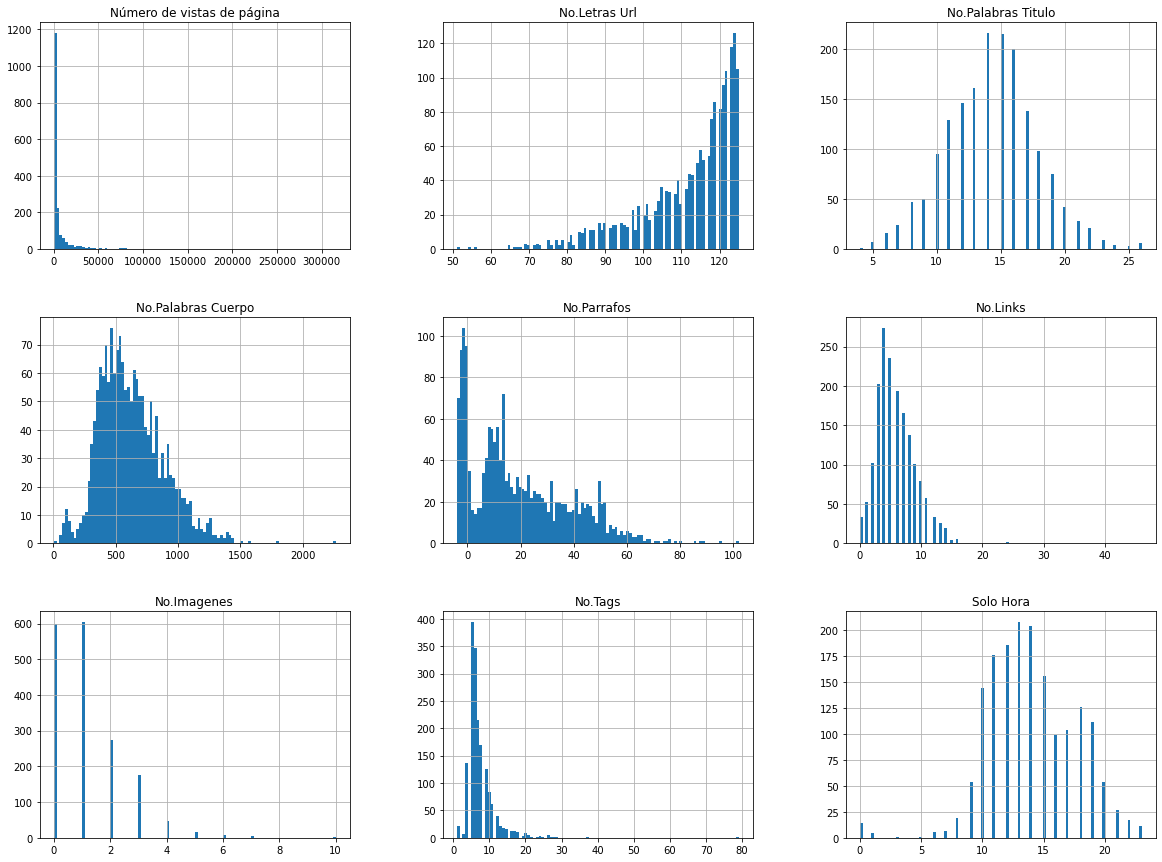

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
dfnotas.hist(bins=100, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [15]:
dfnotas
corr_matrix = dfnotas.corr()
corr_matrix['Número de vistas de página'].sort_values(ascending=False)

Número de vistas de página    1.000000
No.Tags                       0.141190
No.Imagenes                   0.081826
No.Palabras_Titulo            0.053246
No.Letras_Url                 0.034126
Solo_Hora                     0.010086
No.Links                      0.006943
No.Parrafos                  -0.107332
No.Palabras_Cuerpo           -0.120675
editor                             NaN
Name: Número de vistas de página, dtype: float64

Saving figure attribute_histogram_plots


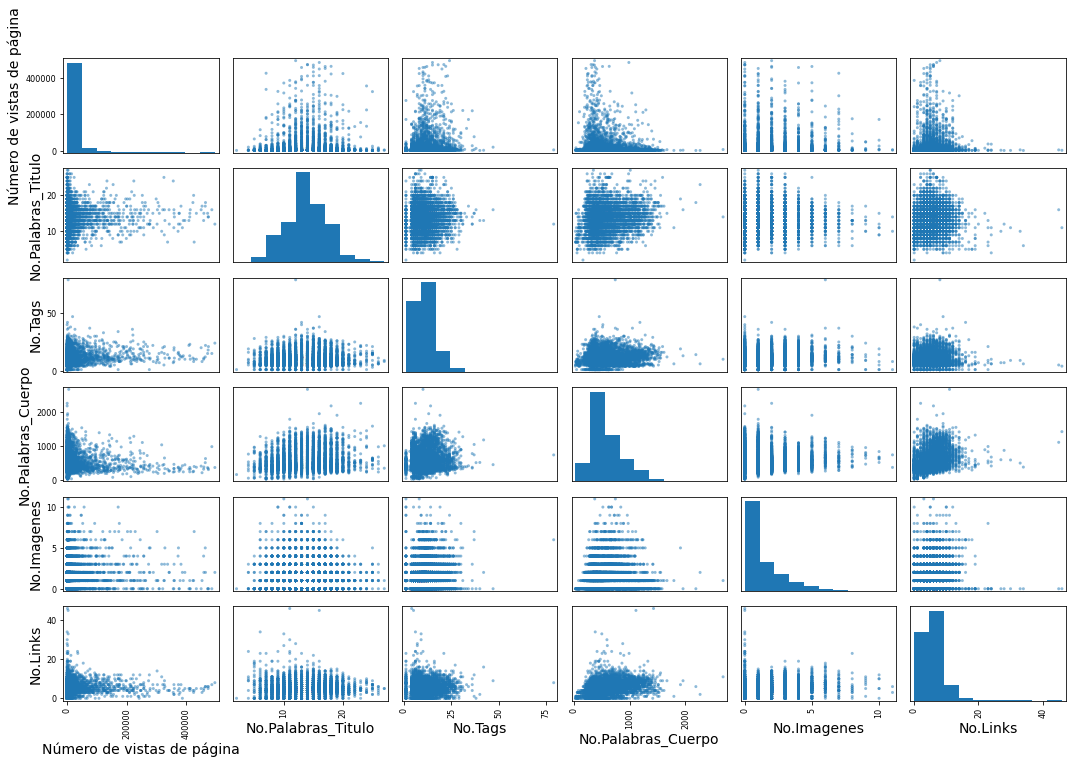

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["Número de vistas de página", "No.Palabras_Titulo","No.Tags","No.Palabras_Cuerpo","No.Imagenes","No.Links"]
scatter_matrix(dfnotas[attributes], figsize=(15, 10))
save_fig("attribute_histogram_plots")

Saving figure attribute_histogram_plots


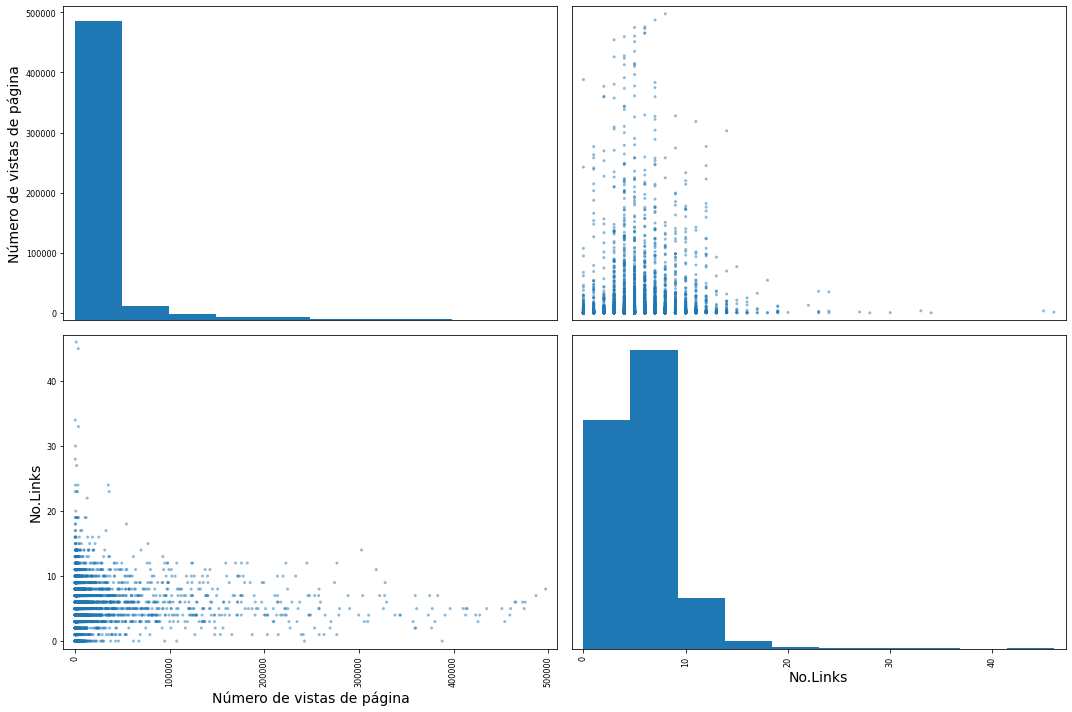

In [94]:
from pandas.plotting import scatter_matrix

attributes = ["Número de vistas de página", "No.Links"]
scatter_matrix(dfnotas[attributes], figsize=(15, 10))
save_fig("attribute_histogram_plots")

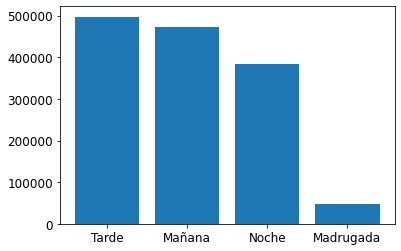

In [18]:
plt.bar( dfnotas['Horario_de_Publicacion'], dfnotas['Número de vistas de página'])
plt.show()


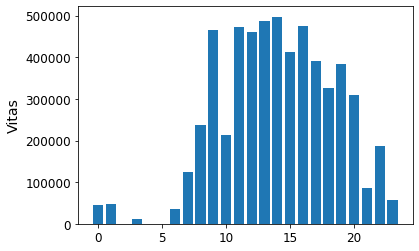

In [19]:
plt.bar( dfnotas['Solo_Hora'], dfnotas['Número de vistas de página'])
plt.ylabel("Vitas")
plt.show()


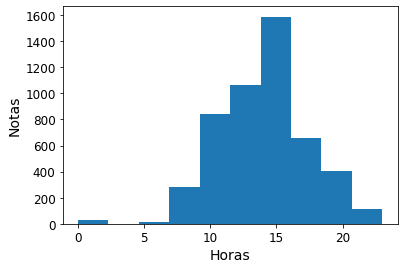

In [20]:
(counts, bins, patches) = plt.hist(dfnotas["Solo_Hora"])
plt.xlabel("Horas")
plt.ylabel("Notas")
plt.show()

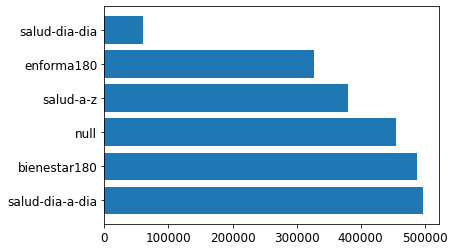

In [21]:
plt.barh( dfnotas['Topic'], dfnotas['Número de vistas de página'])
plt.show()


In [22]:
for i in range(0,len(dfnotas.index)):
    
    if dfnotas.iloc[i]['Topic'] == 'acupuntura' :

IndentationError: expected an indented block (16220344.py, line 3)

In [ ]:
plt.barh( dfnotas['editor'], dfnotas['Número de vistas de página'])
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x_values = dfnotas["Solo_Hora"].unique()

ax.scatter(x = dfnotas["Solo_Hora"], y = dfnotas["Número de vistas de página"])
plt.xlabel("Solo_Hora",fontsize=25)
plt.ylabel("Numero de vistas de pagina")

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (25, 5)
plt.xticks(np.arange(0.7, 12, step=1.4))
plt.hist( dfnotas['Topic'],rwidth=0.9)

plt.show()


# ESTRATIFICACION DE DATOS

In [25]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dfnotas, test_size=0.2, random_state=42)

In [30]:
#test_set.head()

<AxesSubplot:>

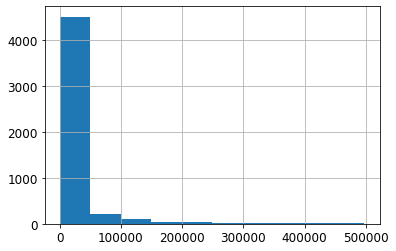

In [24]:
dfnotas["Número de vistas de página"].hist()

In [26]:

dfnotas["Calidad_Nota"] = np.ceil(dfnotas["Número de vistas de página"] / 1.5)

dfnotas["Calidad_Nota"].where(dfnotas["Calidad_Nota"] < 10000, 2, inplace=True)

In [27]:
dfnotas["Calidad_Nota"] = pd.cut(dfnotas["Número de vistas de página"],  #generamos los indices para clasificar las notas
                               bins=[0.,10000., np.inf],
                               labels=[1, 2])

In [28]:
dfnotas["Calidad_Nota"].value_counts()

1    3643
2    1350
Name: Calidad_Nota, dtype: int64

<AxesSubplot:>

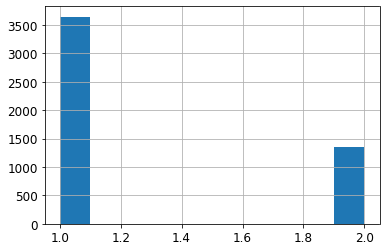

In [29]:
dfnotas["Calidad_Nota"].hist()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dfnotas, dfnotas["Topic"]):
    strat_train_set = dfnotas.loc[train_index]
    strat_test_set = dfnotas.loc[test_index]

In [31]:
strat_test_set["Topic"].value_counts() / len(strat_test_set)

salud-dia-a-dia    0.544545
bienestar180       0.166166
salud-a-z          0.141141
null               0.102102
enforma180         0.033033
salud-dia-dia      0.013013
Name: Topic, dtype: float64

In [32]:
def income_cat_proportions(data):
    return data["Topic"].value_counts() / len(data)

train_set, test_set = train_test_split(dfnotas, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(dfnotas),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [33]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
bienestar180,0.166032,0.166166,0.152152,-8.359988,0.080539
enforma180,0.033247,0.033033,0.032032,-3.653051,-0.642208
null,0.102343,0.102102,0.128128,25.194470,-0.235656
salud-a-z,0.140997,0.141141,0.130130,-7.707423,0.101949
salud-dia-a-dia,0.544362,0.544545,0.542543,-0.334256,0.033514
salud-dia-dia,0.013018,0.013013,0.015015,15.338415,-0.040040


In [34]:
y_train, y_test = strat_train_set["Calidad_Nota"], strat_test_set["Calidad_Nota"]

In [38]:
#for set_ in (strat_train_set, strat_test_set):
#    set_.drop("Calidad_Nota", axis=1, inplace=True)

# ENTRENAMIENTO DEL MODELO DE CLASIFICACION

In [39]:
entrenamiento= strat_train_set.copy() #Copio el df en uno nuevo para entrenar

In [40]:
y_train_buena = (y_train == 2)
y_test_buena = (y_test == 2)  #arrays con true o false en la posicion de las notas con clasificacion 2

In [41]:
entrenamiento=entrenamiento.drop(['Número de vistas de página'],axis=1)
entrenamiento.head(2)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,No.Letras_Url,...,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora
4860,salud180,"28 jun 2022, 23:24:03","Mantén hermosa tu Colocasia ""Black Magic"", ¿có...",2022-06-28,18:24:03,https://www.salud180.com/salud-dia-a-dia/mante...,0.0,_Cómo cuidar una colocasia Back Magic_cómo reg...,Si te encantan las plantas exóticas y no se te...,118,...,665,0,3,3,"{mejor, ambiental, Humedad, mantienes, iStockS...",Si,7,salud-dia-a-dia,Tarde,18
2589,salud180,"10 abr 2021, 14:23:06",Estas son las frutas más caras de Japón: ¿son ...,2021-04-10,9:23:06,https://www.salud180.com/enforma180/estas-son-...,0.0,_salud180_frutas_propiedades frutas_frutas jap...,"Japón es reconocido por su cultura, gastronomí...",106,...,1238,59,8,1,"{mejor, consumen, acuerdo, ninguna, melones, a...",Si,14,enforma180,Mañana,9


In [42]:
sample_incomplete_rows = entrenamiento[entrenamiento.isnull().any(axis=1)].head() #No hay valoren nulos
sample_incomplete_rows

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,No.Letras_Url,...,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,Vocabulario_Cuerpo,Tiene_Tags,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora


# Tratamiento atributos categoricos

In [43]:
topic_cat, horario_cat = entrenamiento[['Topic']],entrenamiento[['Horario_de_Publicacion']]
topic_cat.head(10)

,Topic
4860,salud-dia-a-dia
2589,enforma180
3681,salud-a-z
1057,salud-dia-a-dia
228,salud-dia-a-dia
4005,salud-dia-a-dia
3790,salud-a-z
4416,null
1050,null
680,salud-dia-a-dia


#ENTRENANDO EL MODELO SIN CATEGORICOS

In [44]:
entrenamiento_sincat=entrenamiento.drop(['Mas_Frecuentes_Titulo','sitio','created','title','Fecha','Hora','url','editor','tags','cuerpo','Vocabulario_Cuerpo','Tiene_Tags', 'Topic','Horario_de_Publicacion'], axis=1)
entrenamiento_sincat.head(3)  #elimino los atributos categoricos

,No.Letras_Url,No.Palabras_Titulo,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,No.Tags,Solo_Hora
4860,118,17,665,0,3,3,7,18
2589,106,15,1238,59,8,1,14,9
3681,121,15,337,-4,0,1,8,13


In [45]:
entrenamiento_sincat=entrenamiento_sincat.to_numpy()
#entrenamiento_sincat=entrenamiento_sincat.reshape(1,-1)


In [46]:
entrenamiento_sincat

array([[ 118,   17,  665, ...,    3,    7,   18],
       [ 106,   15, 1238, ...,    1,   14,    9],
       [ 121,   15,  337, ...,    1,    8,   13],
       ...,
       [ 101,   12,  751, ...,    0,   14,   14],
       [ 102,   12,  500, ...,    0,   25,   19],
       [ 121,   24,  237, ...,    0,    7,   15]], dtype=int64)

In [47]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(entrenamiento_sincat, y_train_buena) #se entrena el modelo

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [57]:
#RESULTADOS VIEJOS
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, entrenamiento_sincat, y_train_buena, cv=3, scoring="accuracy")

array([0.86147186, 0.86117137, 0.13882863])

In [48]:
#NUEVOS RESULTADOS
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, entrenamiento_sincat, y_train_buena, cv=3, scoring="accuracy")

array([0.71921922, 0.71675432, 0.72652141])

In [49]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, entrenamiento_sincat, y_train_buena, cv=3)

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_buena, y_train_pred)

array([[2783,  133],
       [ 982,   96]], dtype=int64)

In [51]:
y_train_perfect_predictions = y_train_buena

In [52]:
confusion_matrix(y_train_buena, y_train_perfect_predictions)

array([[2916,    0],
       [   0, 1078]], dtype=int64)

In [53]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_buena, y_train_pred) #SE AUMENTO LA PRECISION

0.4192139737991266

In [55]:
recall_score(y_train_buena, y_train_pred)

0.08905380333951762

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_buena, y_train_pred)

0.14690130068859986

#ENTRENANDO EL MODELO CON CATEGORICOS

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([                                      #pipeline que prepara atributos numericos
   #     ('imputer', SimpleImputer(strategy="median")),
   #     ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])

#entrenamiento_num_tr = num_pipeline.fit_transform(entrenamiento_num) 

In [59]:
entrenamiento=entrenamiento.drop(['Mas_Frecuentes_Titulo','sitio','created','title','Fecha','Hora','url','editor','tags','cuerpo','Vocabulario_Cuerpo','Tiene_Tags'], axis=1)
entrenamiento.head(1) #elimino del dataframe de entramientos los atrbutos que no necesio

,No.Letras_Url,No.Palabras_Titulo,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora
4860,118,17,665,0,3,3,7,salud-dia-a-dia,Tarde,18


In [60]:
entrenamiento_num=entrenamiento.drop(['Topic','Horario_de_Publicacion'], axis=1)

In [61]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [62]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20               #EJECUTAR AQUI

In [63]:
num_attribs = list(entrenamiento_num)
cat_attribs = ["Horario_de_Publicacion","Topic"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

entrenamiento_prepared = full_pipeline.fit_transform(entrenamiento)

In [64]:
entrenamiento_prepared

array([[ 0.69419657,  0.97286258,  0.27928722, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.01492393,  0.39772742,  2.27851187, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86401473,  0.39772742, -0.86512061, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.26810634, -0.46497532,  0.57934537, ...,  0.        ,
         0.        ,  0.        ],
       [-0.21150028, -0.46497532, -0.29640574, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.86401473,  2.98583565, -1.21402543, ...,  0.        ,
         1.        ,  0.        ]])

In [65]:
entrenamiento_prepared.shape

(3994, 18)

In [66]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(entrenamiento_prepared, y_train_buena) #se entrena el modelo

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [67]:
prueba= strat_test_set.copy() #copia el set de test para evalar

In [68]:
prueba=prueba.drop(['Mas_Frecuentes_Titulo','sitio','created','title','Fecha','Hora','url','editor','tags','cuerpo','Vocabulario_Cuerpo','Número de vistas de página','Tiene_Tags'], axis=1)
prueba.head(3) #elimino atributos de texto

,No.Letras_Url,No.Palabras_Titulo,No.Palabras_Cuerpo,No.Parrafos,No.Links,No.Imagenes,No.Tags,Topic,Horario_de_Publicacion,Solo_Hora
3191,121,18,418,4,5,0,5,bienestar180,Noche,21
3236,118,14,1411,33,4,2,15,bienestar180,Tarde,12
2533,70,9,331,13,5,6,16,salud-dia-a-dia,Tarde,15


In [69]:
prueba_prepared = full_pipeline.fit_transform(prueba)

In [70]:
prueba_prepared

array([[ 0.86863034,  1.33900153, -0.58111211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7013241 ,  0.1622586 ,  2.75674113, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97557578, -1.30867007, -0.87355243, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.08327582,  0.75063006, -0.85338413, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.98016783,  1.63318726, -0.84329998, ...,  0.        ,
         1.        ,  0.        ],
       [-0.19097586, -0.42611287, -0.35253807, ...,  1.        ,
         0.        ,  0.        ]])

In [71]:
prueba_prepared.shape

(999, 18)

In [111]:
#some_digit=some_digit.reshape(1, -1) #preparo el dato para probar en el modelo

In [95]:
for i in range(0,len(prueba_prepared)):
    some_digit=prueba_prepared[i]
    some_digit=some_digit.reshape(1,-1)
    if sgd_clf.predict(some_digit):
        print(i , " :",sgd_clf.predict(some_digit))


0  : [ True]
2  : [ True]
3  : [ True]
4  : [ True]
5  : [ True]
7  : [ True]
8  : [ True]
9  : [ True]
10  : [ True]
14  : [ True]
17  : [ True]
19  : [ True]
21  : [ True]
22  : [ True]
24  : [ True]
27  : [ True]
28  : [ True]
29  : [ True]
31  : [ True]
33  : [ True]
34  : [ True]
35  : [ True]
36  : [ True]
37  : [ True]
38  : [ True]
39  : [ True]
41  : [ True]
42  : [ True]
43  : [ True]
44  : [ True]
49  : [ True]
50  : [ True]
51  : [ True]
54  : [ True]
55  : [ True]
56  : [ True]
57  : [ True]
61  : [ True]
62  : [ True]
65  : [ True]
66  : [ True]
67  : [ True]
68  : [ True]
69  : [ True]
71  : [ True]
76  : [ True]
77  : [ True]
79  : [ True]
80  : [ True]
82  : [ True]
84  : [ True]
85  : [ True]
88  : [ True]
90  : [ True]
94  : [ True]
96  : [ True]
97  : [ True]
98  : [ True]
99  : [ True]
101  : [ True]
102  : [ True]
103  : [ True]
104  : [ True]
107  : [ True]
109  : [ True]
110  : [ True]
111  : [ True]
112  : [ True]
113  : [ True]
115  : [ True]
116  : [ True]
11

In [112]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, entrenamiento_prepared, y_train_buena, cv=3, scoring="accuracy")  #Valor anterior

array([0.81818182, 0.85466377, 0.8329718 ])

In [82]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, entrenamiento_prepared, y_train_buena, cv=3, scoring="accuracy") #Nuevo valor

array([0.67867868, 0.6498873 , 0.70473328])

In [75]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, entrenamiento_prepared, y_train_buena, cv=3)

In [76]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_buena, y_train_pred)

array([[2541,  375],
       [ 912,  166]], dtype=int64)

In [77]:
y_train_perfect_predictions = y_train_buena

In [78]:
confusion_matrix(y_train_buena, y_train_perfect_predictions)

array([[2916,    0],
       [   0, 1078]], dtype=int64)

In [117]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_buena, y_train_pred)  #Valor viejo

0.17857142857142858

In [79]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_buena, y_train_pred) #Valor nuevo

0.3068391866913124

In [118]:
recall_score(y_train_buena, y_train_pred) #Valor viejo

0.052083333333333336

In [80]:
recall_score(y_train_buena, y_train_pred) #Valor nuevo

0.15398886827458255

In [119]:
from sklearn.metrics import f1_score
f1_score(y_train_buena, y_train_pred)

0.08064516129032258

In [81]:
from sklearn.metrics import f1_score
f1_score(y_train_buena, y_train_pred)

0.205064854848672